# BioBery fine-tuning for ADE classification

**Goal.** Fine-tune BioBert on the cleaned splits, choose a threshold on validation with a recall target, and evaluate on test.

In [ ]:
from pathlib import Path
import os, sys, json, random, inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    precision_recall_curve, roc_curve, auc,
    average_precision_score, roc_auc_score,
    brier_score_loss, confusion_matrix
)
from sklearn.calibration import calibration_curve

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, Trainer, TrainingArguments, EarlyStoppingCallback
)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# project root + src (same pattern as NB4)
CANDIDATES = [
    Path("/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project"),
    Path("/content/drive/masters_math/capestone/Final_project/Final_project"),
]
PROJECT_ROOT = next((p for p in CANDIDATES if (p/"src"/"utilities.py").exists()), None)
assert PROJECT_ROOT, "Couldn't find src/utilities.py. Check the Drive path."
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
import importlib, src; importlib.reload(src)

from src import (
    set_seed, ensure_dir, choose_text_col, compute_class_weights, save_json,
    plot_confusion, pick_thr_with_recall_floor
)
from src.hf_utils import token_length_stats, make_hf_datasets, WeightedTrainer

# dirs + seed
ARTIFACTS_DIR = ensure_dir(PROJECT_ROOT / "artifacts")
PLOTS_DIR     = ensure_dir(PROJECT_ROOT / "plots")
TRANS_DIR     = ensure_dir(ARTIFACTS_DIR / "transformers" / "biobert")
set_seed(42)
plt.rcParams["figure.dpi"] = 150

BIO_MODEL_ID = "dmis-lab/biobert-base-cased-v1.1"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Data**

In [ ]:
train_df = pd.read_csv(ARTIFACTS_DIR / "train_clean.csv")
val_df   = pd.read_csv(ARTIFACTS_DIR / "val_clean.csv")
test_df  = pd.read_csv(ARTIFACTS_DIR / "test_clean.csv")

TEXT_COL  = choose_text_col(train_df, "text_clean")
LABEL_COL = "label"

for df, name in [(train_df,"train"), (val_df,"val"), (test_df,"test")]:
    assert {TEXT_COL, LABEL_COL}.issubset(df.columns), f"{name} missing columns"
    if "uid" not in df.columns:
        df["uid"] = [f"{name[:2]}_{i:05d}" for i in range(len(df))]

print({"train": train_df.shape, "val": val_df.shape, "test": test_df.shape, "text_col": TEXT_COL})


{'train': (13743, 7), 'val': (1527, 7), 'test': (5626, 7), 'text_col': 'text_clean'}


# **Tokenizer, token lengths, datasets**

Tokenizer and Sequence Length
compute token length quantiles on the training text to gauge typical sequence sizes, then cap the sequence length at 320 tokens. This length covers the vast majority of samples while keeping batch throughput reasonable. The same maximum length is used for train, validation, and test to avoid distribution drift.

Datasets and Collation

Build Hugging Face datasets from the dataframes and use a padding collator so batches are padded dynamically. Labels are integers zero or one, and we retain normalized text from earlier steps only for audit; the model is trained on the cleaned text field.

In [ ]:
biobert_tok = AutoTokenizer.from_pretrained(BIO_MODEL_ID, use_fast=True)

# token lengths on train (q95, q99) and chosen MAX_LEN
stats = token_length_stats(biobert_tok, train_df[TEXT_COL])
p95_tok, p99_tok = stats["q95"], stats["q99"]
MAX_LEN = 320
print(f"token length p95={p95_tok}, p99={p99_tok} | using MAX_LEN={MAX_LEN}")

# encoded datasets
ds_train, ds_val, ds_test, d_collator = make_hf_datasets(
    train_df, val_df, test_df, text_col=TEXT_COL, tokenizer=biobert_tok, max_len=MAX_LEN
)
print(f"datasets: train={len(ds_train)}, val={len(ds_val)}, test={len(ds_test)}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


token length p95=58, p99=78 | using MAX_LEN=320
datasets: train=13743, val=1527, test=5626


# **Training args + Patched WeightedTrainer + Train**

Train with class-weighted cross entropy to counter label imbalance, early stopping with patience of two epochs on validation recall, and AdamW with learning rate 5e-5. Batch size is sixteen for training and sixty four for evaluation, andload the best checkpoint at the end of training.

In [ ]:
# class weights from train
cw = compute_class_weights(train_df[LABEL_COL])  # [w0, w1] ndarray

# version-safe TrainingArguments (same spirit as NB4)
def build_targs(**kw):
    sig = inspect.signature(TrainingArguments.__init__).parameters
    out = dict(
        output_dir=kw.get("output_dir"),
        num_train_epochs=kw.get("num_train_epochs", 10),
        per_device_train_batch_size=kw.get("per_device_train_batch_size", 16),
        per_device_eval_batch_size=kw.get("per_device_eval_batch_size", 64),
        logging_dir=kw.get("logging_dir"),
        logging_steps=50,
        report_to="none",
        warmup_steps=200,
        weight_decay=0.01,
        save_total_limit=2,
        seed=kw.get("seed", 42),
        fp16=kw.get("fp16", torch.cuda.is_available()),
        learning_rate=kw.get("learning_rate", 5e-5),
    )
    if "evaluation_strategy" in sig: out["evaluation_strategy"] = "epoch"
    elif "eval_strategy" in sig:     out["eval_strategy"] = "epoch"
    if "save_strategy" in sig:             out["save_strategy"] = "epoch"
    if "load_best_model_at_end" in sig:    out["load_best_model_at_end"] = True
    if "metric_for_best_model" in sig:     out["metric_for_best_model"]  = kw.get("select_metric", "eval_recall")
    if "greater_is_better" in sig:         out["greater_is_better"]      = kw.get("greater_is_better", True)
    return TrainingArguments(**out)

biobert_args = build_targs(
    output_dir=str(TRANS_DIR / "results"),
    logging_dir=str(TRANS_DIR / "logs"),
    num_train_epochs=10,
    seed=42,
    select_metric="eval_recall",
    greater_is_better=True,
    learning_rate=5e-5
)

# metrics that also log PR/ROC AUC (version-safe on EvalPrediction/tuple)
def compute_metrics(eval_pred):
    logits, labels = eval_pred if isinstance(eval_pred, tuple) else (eval_pred.predictions, eval_pred.label_ids)
    if isinstance(logits, tuple): logits = logits[0]
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
    y_pred = np.asarray(logits).argmax(-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, y_pred, average="binary", zero_division=0)
    acc = accuracy_score(labels, y_pred)
    ap  = average_precision_score(labels, probs)
    ra  = roc_auc_score(labels, probs)
    return {"accuracy": acc, "f1": f1, "precision": p, "recall": r, "pr_auc": ap, "roc_auc": ra}

# patch WeightedTrainer to accept new kwargs like num_items_in_batch
class PatchedWeightedTrainer(WeightedTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits", outputs[0])
        weight = getattr(self, "class_weights", None)
        if weight is not None:
            weight = torch.tensor(weight, dtype=torch.float).to(logits.device) if not torch.is_tensor(weight) else weight.to(logits.device)
        loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

biobert_model = AutoModelForSequenceClassification.from_pretrained(BIO_MODEL_ID, num_labels=2)

trainer = PatchedWeightedTrainer(
    model=biobert_model,
    args=biobert_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    data_collator=d_collator,
    tokenizer=biobert_tok,
    compute_metrics=compute_metrics,
    class_weights=cw
)

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))

_ = trainer.train()
print("best_checkpoint:", trainer.state.best_model_checkpoint)
print("best eval_recall:", trainer.state.best_metric)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/src/hf_utils.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `PatchedWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Pr Auc,Roc Auc
1,0.229700,0.232830,0.950884,0.870466,0.854237,0.887324,0.924699,0.977382
2,0.209500,0.199897,0.947610,0.863481,0.837748,0.890845,0.936534,0.983254
3,0.091900,0.327450,0.946955,0.864322,0.824281,0.908451,0.936137,0.984474
4,0.038200,0.407838,0.954158,0.878893,0.863946,0.894366,0.934517,0.984169
5,0.044000,0.354646,0.949574,0.868825,0.841584,0.897887,0.933524,0.985148


best_checkpoint: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/biobert/results/checkpoint-2577
best eval_recall: 0.9084507042253521


# **Probs (VAL/TEST) + threshold**

threshold on validation using a recall floor of 0.90.

The procedure maximizes precision while meeting the recall target (a tie break on f1).

The chosen threshold is then applied on the test set for all point metrics.

In [ ]:
def get_labels_probs(trainer, dataset):
    out = trainer.predict(dataset)
    logits = out.predictions if not isinstance(out.predictions, tuple) else out.predictions[0]
    probs = torch.softmax(torch.tensor(logits), dim=1).numpy()[:, 1]
    return out.label_ids, probs

d_val_y,  d_val_p  = get_labels_probs(trainer, ds_val)
d_test_y, d_test_p = get_labels_probs(trainer, ds_test)

RECALL_FLOOR = 0.900
tv_bio_thr, stats = pick_thr_with_recall_floor(d_val_y, d_val_p, floor=RECALL_FLOOR)

print("VAL threshold:", f"{tv_bio_thr:.3f}")
print("VAL metrics at chosen threshold:",
      f"Precision={stats['precision']:.3f} | Recall={stats['recall']:.3f} | F1={stats['f1']:.3f} | PR-AUC={stats['pr_auc']:.3f}")

VAL threshold: 0.777
VAL metrics at chosen threshold: Precision=0.837 | Recall=0.905 | F1=0.870 | PR-AUC=0.936


# **Save artifacts (model, tokenizer, preds, thresholds, metrics)**

In [ ]:
MODEL_DIR = ensure_dir(TRANS_DIR / "model")
PRED_DIR  = ensure_dir(TRANS_DIR / "preds")

# model + tokenizer
trainer.model.save_pretrained(MODEL_DIR)
biobert_tok.save_pretrained(MODEL_DIR)

# stable IDs from the split
va_ids = val_df["uid"].astype(str).values
te_ids = test_df["uid"].astype(str).values

pd.DataFrame({"id": va_ids, "y_true": d_val_y,  "y_score": d_val_p}).to_csv(PRED_DIR/"val_probs.csv",  index=False)
pd.DataFrame({"id": te_ids, "y_true": d_test_y, "y_score": d_test_p}).to_csv(PRED_DIR/"test_probs.csv", index=False)

def pr_auc(y,p):
    pr_p, pr_r, _ = precision_recall_curve(y,p); return float(auc(pr_r, pr_p))
val_ap  = pr_auc(d_val_y, d_val_p)
test_ap = pr_auc(d_test_y, d_test_p)

d_test_hat = (d_test_p >= tv_bio_thr).astype(int)
tP, tR, tF1, _ = precision_recall_fscore_support(d_test_y, d_test_hat, average="binary", zero_division=0)
tAcc = accuracy_score(d_test_y, d_test_hat)

save_json({"strategy":"recall_floor","floor":float(RECALL_FLOOR),
           "best_threshold":float(tv_bio_thr)}, TRANS_DIR/"thresholds.json")

save_json({"pr_auc": val_ap,
           "val_at_best": {"precision": float(stats["precision"]), "recall": float(stats["recall"]),
                           "f1": float(stats["f1"]), "thr": float(tv_bio_thr)}},
          TRANS_DIR/"metrics_val.json")

save_json({"threshold": float(tv_bio_thr), "precision": float(tP), "recall": float(tR),
           "f1": float(tF1), "accuracy": float(tAcc), "pr_auc": float(test_ap)},
          TRANS_DIR/"metrics_test.json")

print("Saved:", {"model_dir": str(MODEL_DIR),
                "preds": [str(PRED_DIR/'val_probs.csv'), str(PRED_DIR/'test_probs.csv')],
                "thresholds": str(TRANS_DIR/'thresholds.json')})


Saved: {'model_dir': '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/biobert/model', 'preds': ['/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/biobert/preds/val_probs.csv', '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/biobert/preds/test_probs.csv'], 'thresholds': '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/biobert/thresholds.json'}


# **PR/ROC plots**

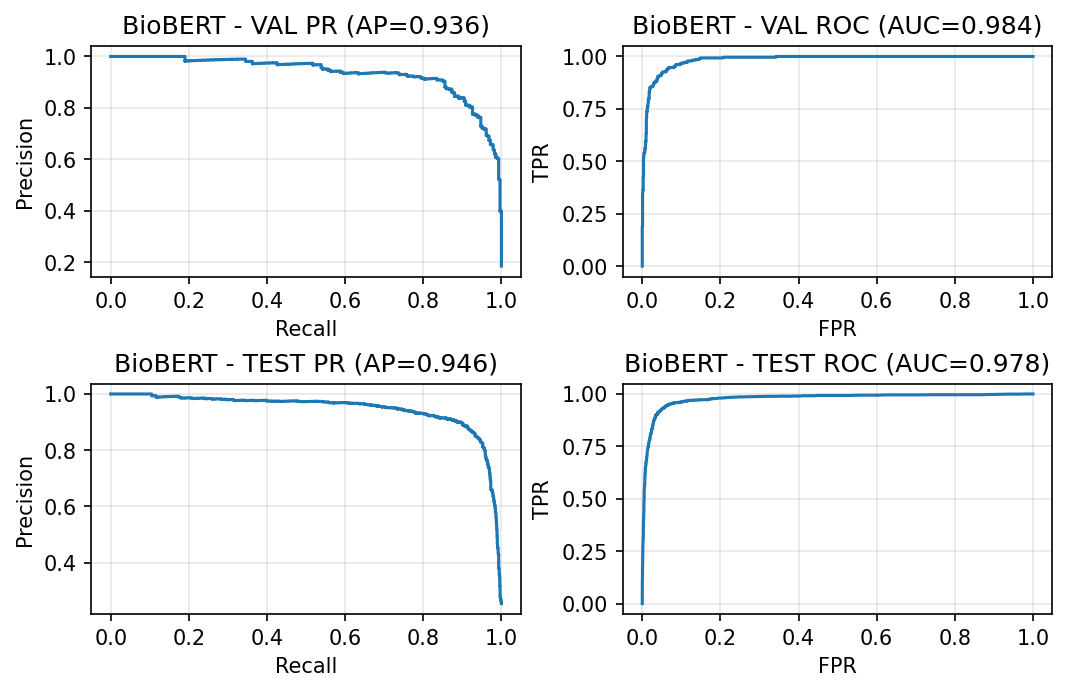

Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/biobert_val_test_pr_roc_grid.png


In [ ]:
def plot_val_test_grid(y_va, p_va, y_te, p_te, model_name: str, out_png: Path):
    pr_p_va, pr_r_va, _ = precision_recall_curve(y_va, p_va)
    fpr_va, tpr_va, _   = roc_curve(y_va, p_va)
    pr_p_te, pr_r_te, _ = precision_recall_curve(y_te, p_te)
    fpr_te, tpr_te, _   = roc_curve(y_te, p_te)

    ap_va  = average_precision_score(y_va, p_va)
    ap_te  = average_precision_score(y_te, p_te)
    auc_va = auc(fpr_va, tpr_va)
    auc_te = auc(fpr_te, tpr_te)

    fig, axes = plt.subplots(2, 2, figsize=(7, 4.5), constrained_layout=True)

    ax = axes[0,0]; ax.step(pr_r_va, pr_p_va, where="post")
    ax.set_title(f"{model_name} - VAL PR (AP={ap_va:.3f})"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.grid(alpha=0.3)

    ax = axes[0,1]; ax.plot(fpr_va, tpr_va)
    ax.set_title(f"{model_name} - VAL ROC (AUC={auc_va:.3f})"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.grid(alpha=0.3)

    ax = axes[1,0]; ax.step(pr_r_te, pr_p_te, where="post")
    ax.set_title(f"{model_name} - TEST PR (AP={ap_te:.3f})"); ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.grid(alpha=0.3)

    ax = axes[1,1]; ax.plot(fpr_te, tpr_te)
    ax.set_title(f"{model_name} - TEST ROC (AUC={auc_te:.3f})"); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.grid(alpha=0.3)

    out_png.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_png, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", out_png)

plot_val_test_grid(d_val_y, d_val_p, d_test_y, d_test_p,
                   "BioBERT", PLOTS_DIR / "biobert_val_test_pr_roc_grid.png")


Validation PR-AUC about 0.936 and ROC-AUC about 0.984.

Test PR-AUC about 0.946 and ROC-AUC about 0.978.

Curves are tight between validation and test, showing good generalization.

High precision is maintained across a wide recall range.

# **Confusion matrix**

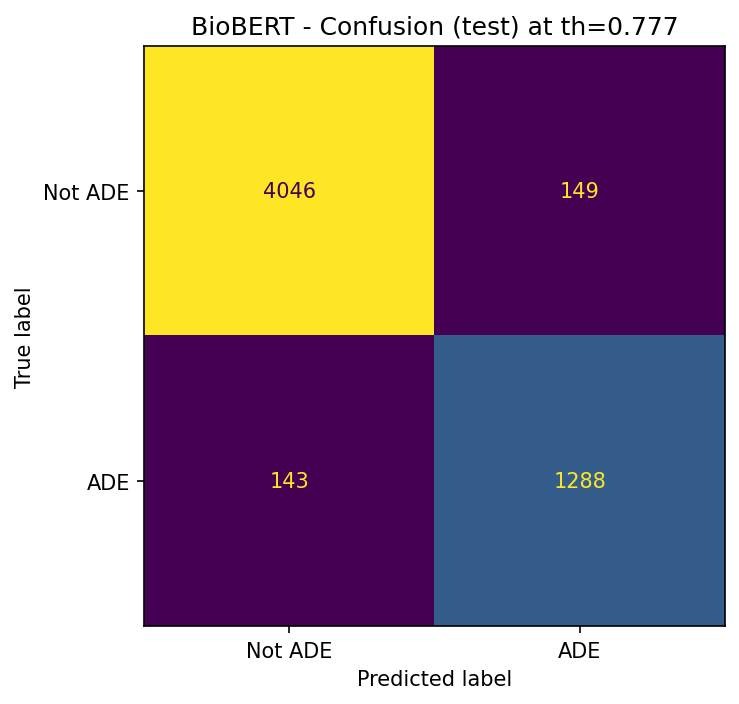

TN, FP, FN, TP = 4046 149 143 1288
Precision=0.896 | Recall=0.900 | F1=0.898 | Accuracy=0.948
Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/biobert_test_confusion.png


In [ ]:
y_hat = (d_test_p >= tv_bio_thr).astype(int)
cm = confusion_matrix(d_test_y, y_hat, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
prec = tp / (tp + fp + 1e-12)
rec  = tp / (tp + fn + 1e-12)
f1   = 2 * prec * rec / (prec + rec + 1e-12)
acc  = (tp + tn) / cm.sum()

out_cm = PLOTS_DIR / "biobert_test_confusion.png"
plot_confusion(d_test_y, y_hat, out_cm, title=f"BioBERT - Confusion (test) at th={tv_bio_thr:.3f}")

print("TN, FP, FN, TP =", tn, fp, fn, tp)
print(f"Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | Accuracy={acc:.3f}")
print("Saved:", out_cm)


Low false negatives at the recall target with modest false positives.

Better overall balance than the TF-IDF baselines.

# **Calibration + histogram**

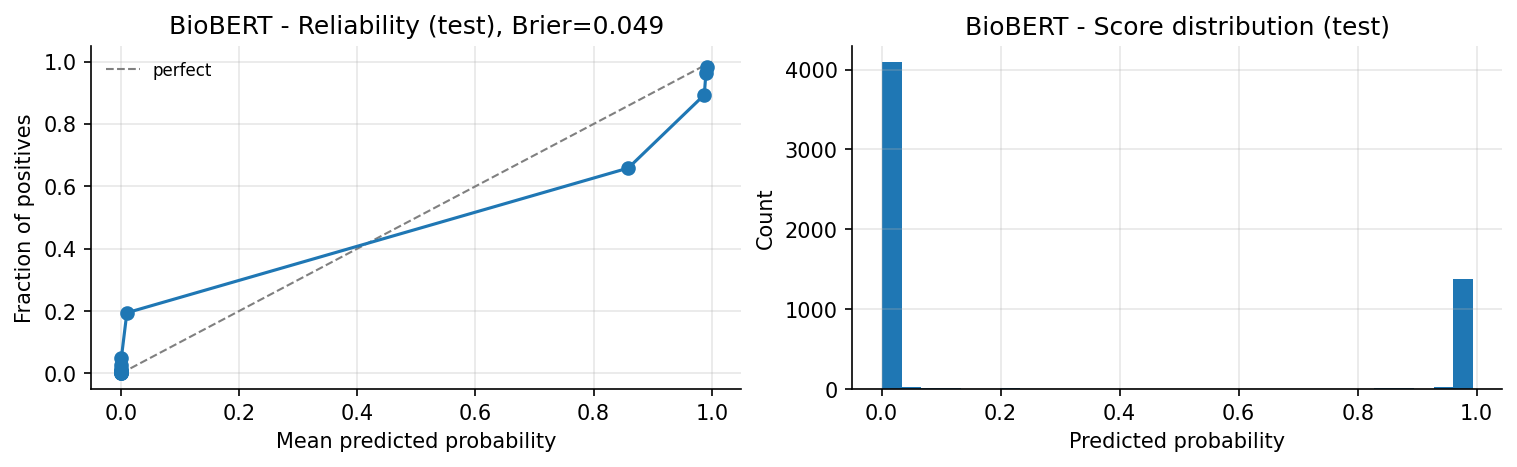

Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/biobert_test_calib_and_hist.png


In [ ]:
prob_true, prob_pred = calibration_curve(d_test_y, d_test_p, n_bins=15, strategy="quantile")
brier = brier_score_loss(d_test_y, d_test_p)

fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

ax = axes[0]
ax.plot([0, 1], [0, 1], linestyle="--", linewidth=1, color="gray", label="perfect")
ax.plot(prob_pred, prob_true, marker="o")
ax.set_xlabel("Mean predicted probability"); ax.set_ylabel("Fraction of positives")
ax.set_title(f"BioBERT - Reliability (test), Brier={brier:.3f}")
ax.grid(alpha=0.3); ax.legend(frameon=False, fontsize=8)
for s in ("top", "right"): ax.spines[s].set_visible(False)

ax = axes[1]
ax.hist(d_test_p, bins=30, histtype="stepfilled")
ax.set_xlabel("Predicted probability"); ax.set_ylabel("Count")
ax.set_title("BioBERT - Score distribution (test)")
ax.grid(alpha=0.3)
for s in ("top", "right"): ax.spines[s].set_visible(False)

out_fig = PLOTS_DIR / "biobert_test_calib_and_hist.png"
fig.savefig(out_fig, dpi=200, bbox_inches="tight")
plt.show()
print("Saved:", out_fig)


Reliability curve is close to ideal at higher scores.

Score histogram shows clear separation between classes.

# **Top FP/FN tables**

In [ ]:
ERR_DIR = ensure_dir(TRANS_DIR / "errors")

df = test_df.reset_index(drop=True).copy()
df["y_true"] = d_test_y
df["y_prob"] = d_test_p
df["y_pred"] = (df["y_prob"] >= tv_bio_thr).astype(int)
df["err"] = np.where((df["y_true"]==0) & (df["y_pred"]==1), "FP",
              np.where((df["y_true"]==1) & (df["y_pred"]==0), "FN", ""))

id_col = "uid" if "uid" in df.columns else None
cols = ([id_col] if id_col else []) + [TEXT_COL, "y_true", "y_prob", "y_pred", "err"]

fp = (df[df.err=="FP"].sort_values("y_prob", ascending=False)
        .assign(text_snip=lambda x: x[TEXT_COL].astype(str).str.slice(0, 220)))
fn = (df[df.err=="FN"].sort_values("y_prob", ascending=True)
        .assign(text_snip=lambda x: x[TEXT_COL].astype(str).str.slice(0, 220)))

display(fp[cols + ["text_snip"]].head(10))
display(fn[cols + ["text_snip"]].head(10))

fp_path = ERR_DIR / "biobert_test_fp_examples.csv"
fn_path = ERR_DIR / "biobert_test_fn_examples.csv"
fp[cols + ["text_snip"]].to_csv(fp_path, index=False)
fn[cols + ["text_snip"]].to_csv(fn_path, index=False)
print("Saved:", fp_path, "|", fn_path)

print("\n#FP examples")
for x in fp[TEXT_COL].head(5):
    print("-", str(x)[:220])

print("\n#FN examples")
for x in fn[TEXT_COL].head(5):
    print("-", str(x)[:220])


,uid,text_clean,y_true,y_prob,y_pred,err,text_snip
1610,te_1610,One woman received ifosfamide 1000 mg/m2 (1 h ...,0,0.991985,1,FP,One woman received ifosfamide 1000 mg/m2 (1 h ...
5173,te_5173,RESULTS: Four patients had high intraocular pr...,0,0.991907,1,FP,RESULTS: Four patients had high intraocular pr...
666,te_666,"Both patients developed a severe, sustained hy...",0,0.991406,1,FP,"Both patients developed a severe, sustained hy..."
44,te_44,Anaphylactic/anaphylactoid reactions to methot...,0,0.991373,1,FP,Anaphylactic/anaphylactoid reactions to methot...
3809,te_3809,Laboratory tests revealed cyclosporine nephrot...,0,0.991238,1,FP,Laboratory tests revealed cyclosporine nephrot...
4662,te_4662,The neurological manifestations developed with...,0,0.991015,1,FP,The neurological manifestations developed with...
4838,te_4838,Interferon-induced sarcoidosis is well documen...,0,0.990910,1,FP,Interferon-induced sarcoidosis is well documen...
2343,te_2343,Hypersensitivity reaction to sulindac (Clinoril).,0,0.990732,1,FP,Hypersensitivity reaction to sulindac (Clinoril).
5115,te_5115,We observed intracranial hemorrhagic infarcts ...,0,0.990642,1,FP,We observed intracranial hemorrhagic infarcts ...
2318,te_2318,Drug eruption associated with sulfonamide trea...,0,0.990533,1,FP,Drug eruption associated with sulfonamide trea...


,uid,text_clean,y_true,y_prob,y_pred,err,text_snip
4557,te_4557,The cough continued for the duration of therap...,1,0.000554,0,FN,The cough continued for the duration of therap...
4324,te_4324,She continued to receive regular insulin 4 tim...,1,0.000558,0,FN,She continued to receive regular insulin 4 tim...
3378,te_3378,She was placed on adjuvant Adriamycin (doxorub...,1,0.000560,0,FN,She was placed on adjuvant Adriamycin (doxorub...
2950,te_2950,NMS is a drug-related response to various medi...,1,0.000563,0,FN,NMS is a drug-related response to various medi...
1787,te_1787,Methotrexate is an effective but potentially t...,1,0.000564,0,FN,Methotrexate is an effective but potentially t...
4379,te_4379,Evaluation revealed elevated serum LTG levels ...,1,0.000576,0,FN,Evaluation revealed elevated serum LTG levels ...
3270,te_3270,The vomiting occurred on switching to differen...,1,0.000585,0,FN,The vomiting occurred on switching to differen...
4644,te_4644,Pilocarpine toxicity and the treatment of xero...,1,0.000586,0,FN,Pilocarpine toxicity and the treatment of xero...
1924,te_1924,Intensive high-flux hemodiafiltration is often...,1,0.000592,0,FN,Intensive high-flux hemodiafiltration is often...
3615,te_3615,A 68-year-old female patient with advanced ova...,1,0.000594,0,FN,A 68-year-old female patient with advanced ova...


Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/biobert/errors/biobert_test_fp_examples.csv | /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/transformers/biobert/errors/biobert_test_fn_examples.csv

#FP examples
- One woman received ifosfamide 1000 mg/m2 (1 h infusion on days 1-5); confusion, lethargy, and speech deterioration developed on day 3.
- RESULTS: Four patients had high intraocular pressure after intravitreal ranibizumab 0.5 mg.
- Both patients developed a severe, sustained hypothyroidism requiring thyroxine treatment for one year or more after stopping alpha interferon.
- Anaphylactic/anaphylactoid reactions to methotrexate are rare.
- Laboratory tests revealed cyclosporine nephrotoxicity, cytomegalovirus infection, and prediabetes.

#FN examples
- The cough continued for the duration of therapy with quinapril.
- She continued to receive regular insulin 4 times per day over the follo